In [6]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

# Our First Bots:

In [3]:
%%writefile rock.py
def rock(observation, configuration):
    return 0

Overwriting rock.py


In [4]:
%%writefile paper.py

def paper(observation, configuration):
    return 1

Writing paper.py


In [5]:
%%writefile scissors.py

def scissors(observation, configuration):
    return 2

Writing scissors.py


# Mirroring our Opponent

In [17]:
%%writefile mirror.py

def copy_opponent (observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return 1 # start with scissors

Overwriting mirror.py


# Reacting with Lag

In [18]:
%%writefile switched.py

def copy_opponent (observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % 3
    else:
        return 1

Writing switched.py


# Nash Equilibrium (random)

In [23]:
%%writefile nash_equilibrium.py

import random

def nash_equilibrium(observation, configuration):
    return random.randint(0, 2)

Writing nash_equilibrium.py


# Evaluating our Bots!

In [10]:
# pip install kaggle_environments
from kaggle_environments import make, evaluate

Loading environment football failed: No module named 'gfootball'


In [19]:
env = make("rps", configuration={"episodeSteps": 1000})

# Battle example: invert_my_last_action vs copy_opponent_agent
env.run(["mirror.py", "switched.py"])

env.render(mode="ipython", width=500, height=450)

In [12]:
evaluate("rps", ["rock.py", "scissors.py"], configuration={"episodeSteps": 1000})

[[500.0, -500.0]]

In [24]:
bot_names = [
    "rock", 
    "paper", 
    "scissors", 
    "mirror",
    "switched",
    "nash_equilibrium"
]
list_agents = [agent_name + ".py" for agent_name in bot_names]

scores = np.zeros((len(bot_names), len(bot_names)), dtype=int)

In [25]:
print("Simulation of battles:")

for i in range(len(bot_names)):
    for j in range(i + 1, len(bot_names)):
        print(f"LOG: {bot_names[i]} vs {bot_names[j]}", end="\r")
        
        current_score = evaluate(
            "rps", 
            [list_agents[i], list_agents[j]], 
            configuration={"episodeSteps": 1000}
        )
        
        scores[i, j] = current_score[0][0]
        scores[j, i] = current_score[0][1]
    
    print()

Simulation of battles:
LOG: rock vs nash_equilibrium
LOG: paper vs nash_equilibrium
LOG: scissors vs nash_equilibrium
LOG: mirror vs nash_equilibrium
LOG: switched vs nash_equilibrium



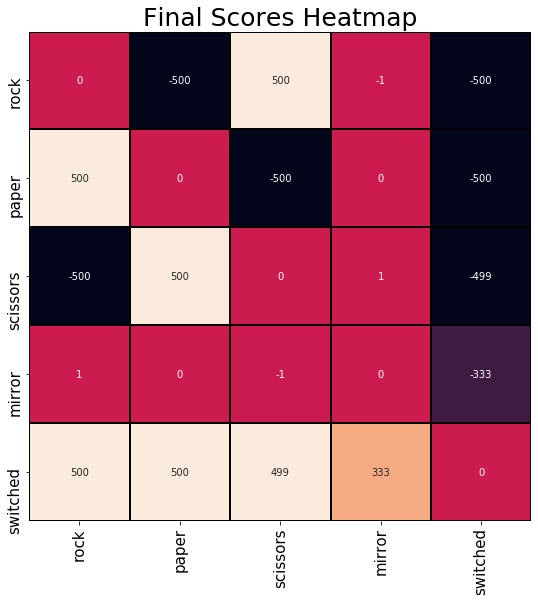

In [22]:
df_scores = pd.DataFrame(
    scores, 
    index=bot_names, 
    columns=bot_names,
)

plt.figure(figsize=(9, 9))
sns.heatmap( df_scores, annot=True, cbar=False, linewidths=1, linecolor='black', fmt='d')
plt.title('Final Scores Heatmap', fontsize=25)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15);